## AJILE 12 Data

In [1]:
from temporaldata import Data
import h5py
from datetime import timedelta

path = "/home/mila/s/sobralm/brainsets/data/processed/peterson_brunton_pose_trajectory_2022/AJILE12_P01_20000107_ses7_pose_trajectories.h5"
file = h5py.File(path, "r")
data = Data.from_hdf5(file, lazy=True)

### Basic information

In [2]:
print(f"Sampling rate: {data.ecog.sampling_rate} Hz")
print(f"Number of channels: {len(data.channels)}")
duration = timedelta(seconds=(data.ecog.domain.end - data.ecog.domain.start)[0])  
print(f"Duration: {duration} seconds")

Sampling rate: 500.0 Hz
Number of channels: 94
Duration: 15:28:37.584000 seconds


### Plot the data

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Plot 10 seconds of 8 channels in 8 horizontal subplots
sampling_rate = data.ecog.sampling_rate
seconds_to_plot = 10
n_channels_to_plot = 8
start_time = 100
start_time_idx = int(start_time * sampling_rate)
end_time = start_time + seconds_to_plot
end_time_idx = int(end_time * sampling_rate)

fig, axes = plt.subplots(n_channels_to_plot, 1, figsize=(15, 8), sharex=True)
time_axis = (np.arange(end_time_idx - start_time_idx) / sampling_rate)

signal = data.ecog.signal[start_time_idx:end_time_idx, :n_channels_to_plot]

for ch in range(n_channels_to_plot):
    axes[ch].plot(time_axis, signal[:, ch])
    axes[ch].set_ylabel(f"Ch {ch+1}")
    axes[ch].set_xlim([0, seconds_to_plot])
    axes[ch].grid(True)
axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

### Show the pose data

Pose data is stored in the `pose` attribute of the `Data` object.

It contains the following joints:
 * l_ear
 * r_ear
 * l_shoulder
 * r_shoulder
 * l_elbow
 * r_elbow
 * l_wrist
 * r_wrist
 * nose

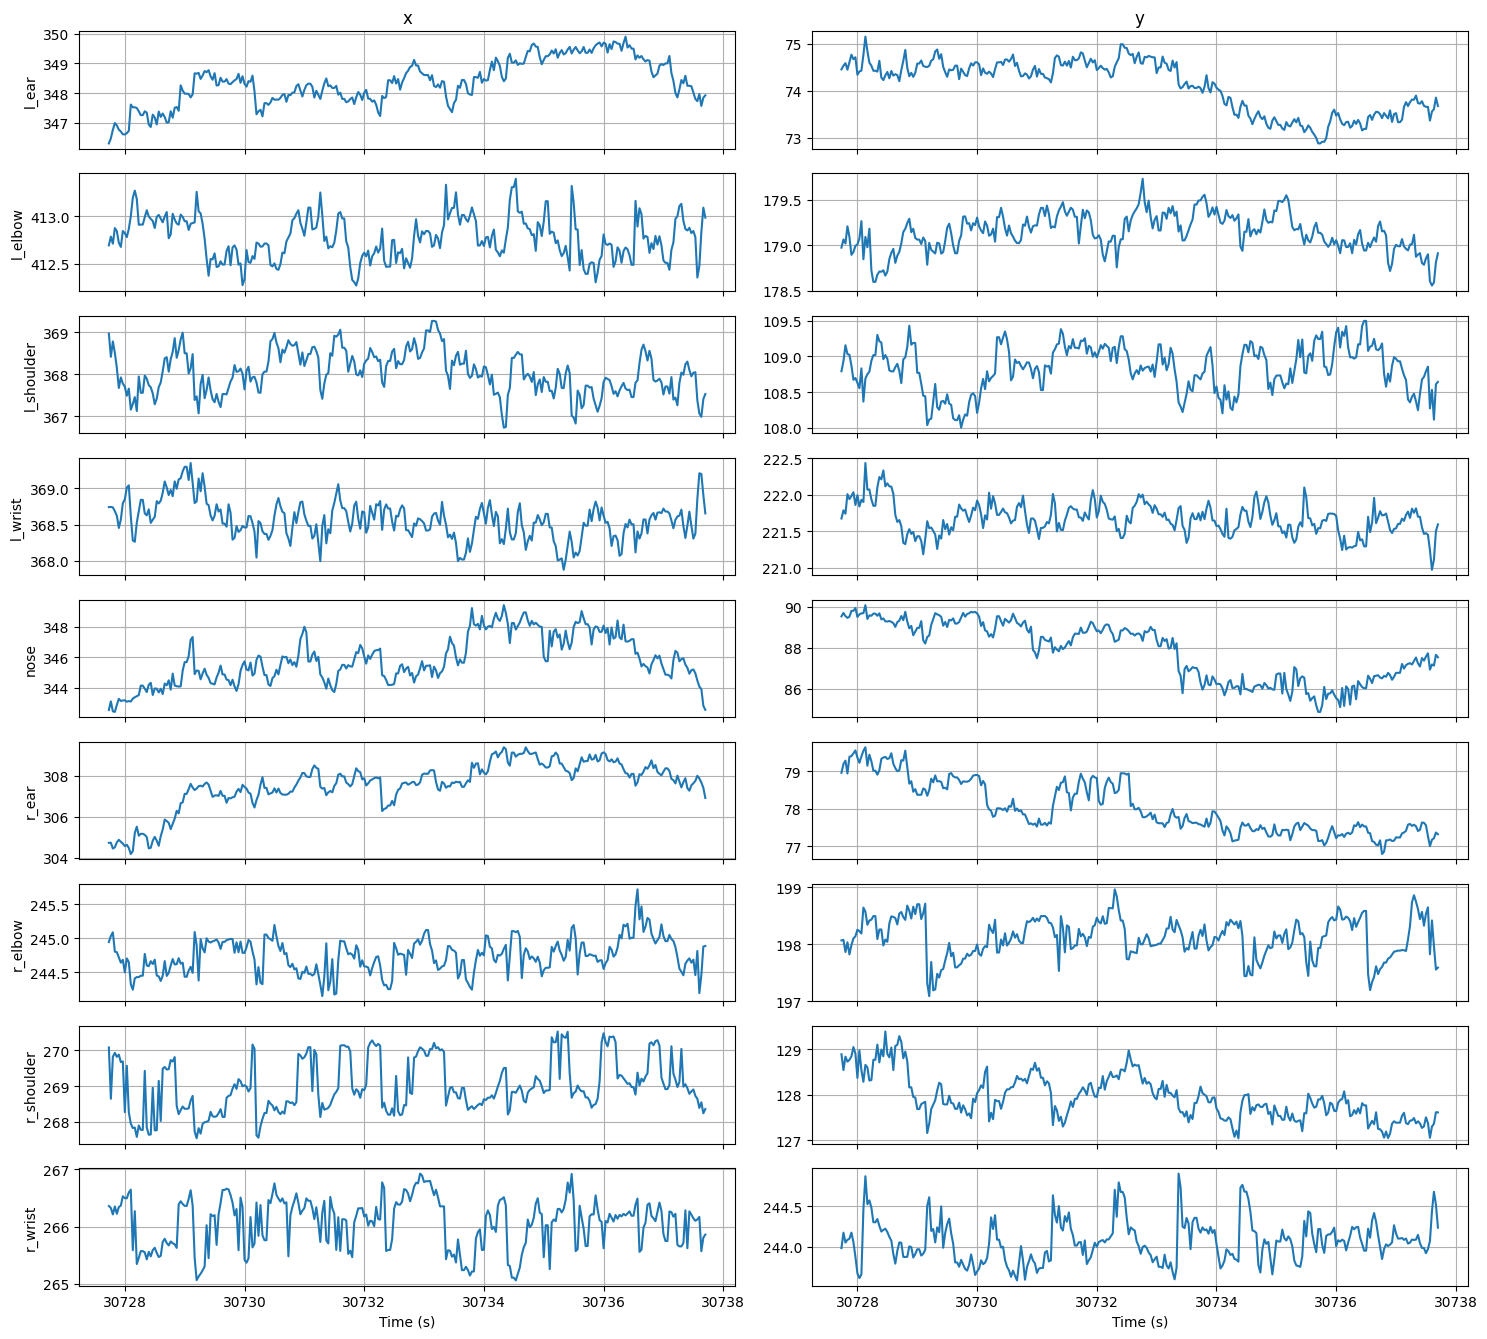

In [ ]:
# Plot 10 seconds of each joint, with each row as a joint and columns as x/y
sampling_rate = data.pose.sampling_rate
seconds_to_plot = 10

joints = list(data.pose.keys())
n_joints = len(joints)
coords = ['x', 'y']

fig, axes = plt.subplots(n_joints, 2, figsize=(15, 1.5 * n_joints), sharex=True)
fig.subplots_adjust(hspace=0.5)

# Use pose sampling, not ECoG
# We'll use the first joint (l_ear) to find the first non-nan frame
nan_mask = np.isnan(data.pose.l_ear)
start_index = int(np.where(~nan_mask)[0][0]) + 1000
end_index = start_index + int(seconds_to_plot * sampling_rate)
time_axis = np.arange(start_index, end_index) / sampling_rate

for i, joint in enumerate(joints):
    joint_data = data.pose.__getattribute__(joint)[start_index:end_index]
    for j, coord in enumerate(coords):
        axes[i, j].plot(time_axis, joint_data[:, j])
        if i == 0:
            axes[i, j].set_title(coord)
        if j == 0:
            axes[i, j].set_ylabel(joint)
        axes[i, j].grid(True)
axes[-1, 0].set_xlabel("Time (s)")
axes[-1, 1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()


### Behavior Data (Classification)

There are two types of Behavior Data:
 * Active VS Inactive
 * Task classification: Eat, Talk, TV, Computer/phone, Other activity



In [ ]:
behavior = data.behavior_trials
behavior.behavior_labels

array([b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'

In [ ]:
import pandas as pd
behavior = data.behavior_trials

print(f"Number of trials in session: {len(behavior.start)}")
print(f"Number of active trials: {np.sum(behavior.active)}")
print(f"Number of inactive trials: {np.sum(~behavior.active)}")

# Compute the number of trials with each of the interesting behaviors
interesting_intervals = behavior.select_by_mask(behavior.active)
unique, counts = np.unique(interesting_intervals.behavior_labels, return_counts=True)
table = pd.DataFrame({"behavior": unique, "count": counts}, index=range(len(unique)))
for index, (u, c) in enumerate(zip(unique, counts)):
    time_in_behavior = sum([end - start for start, end, label in zip(interesting_intervals.start, interesting_intervals.end, interesting_intervals.behavior_labels) if label == u])
    table.loc[index, "time"] = timedelta(seconds=time_in_behavior)
print("Distribution of Active Trials:")
table


Number of trials in session: 920


NameError: name 'np' is not defined

## Exploring the Dataset Class

In [16]:
from brainsets.datasets import PetersonBruntonPoseTrajectory2022

dataset = PetersonBruntonPoseTrajectory2022(
    root="data/processed",
    task_type="pose_estimation",
    split_type="intrasession",
    fold_num=0,
    recording_ids=["AJILE12_P01_20000102_ses3_pose_trajectories"],
)

In [17]:
duration = 0
for split in ["train", "valid", "test"]: 
    intervals = dataset.get_sampling_intervals(split=split)['AJILE12_P01_20000102_ses3_pose_trajectories']
    duration += sum(intervals.end - intervals.start)
print(f"Total duration: {duration}")

Total duration: 69156.27233333327


In [18]:
dataset = PetersonBruntonPoseTrajectory2022(
    root="data/processed",
    task_type="pose_estimation",
    split_type="intersubject",
    fold_num=0,
    recording_ids=["AJILE12_P01_20000102_ses3_pose_trajectories"],
)
intervals = dataset.get_sampling_intervals(split="train")['AJILE12_P01_20000102_ses3_pose_trajectories']
total_duration = sum(intervals.end - intervals.start)
print(f"Total duration: {total_duration}")


Total duration: 69156.27233333327
